# Growth Rate Analysis

See [this discussion of analyzing growth rates.](https://www.unescap.org/sites/default/files/Stats_Brief_Apr2015_Issue_07_Average-growth-rate.pdf)

In [2]:
import seaborn as sns
import metapack as mp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rowgenerators as rg
import fiona
import rasterio
import rasterio.mask
from IPython.display import display 
from rasterio.plot import reshape_as_raster, reshape_as_image, show
from tqdm.notebook import tqdm
from requests import get  # to make GET request
import boto3
import h5py 

%matplotlib inline
sns.set_context('notebook')

In [9]:
n = 20
r = .14 # Input growth rate
x0 = 1 # Initial value
years = np.linspace(0,n-1,num=n)
years

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19.])

Simple annual compounding: 

$$ x_t = x_0(1+r)^t \tag{1}$$

In [21]:
x_geo = np.array([ x0*(r+1)**year for year in years])
x_geo

array([ 1.        ,  1.14      ,  1.2996    ,  1.481544  ,  1.68896016,
        1.92541458,  2.19497262,  2.50226879,  2.85258642,  3.25194852,
        3.70722131,  4.2262323 ,  4.81790482,  5.49241149,  6.2613491 ,
        7.13793798,  8.1372493 ,  9.2764642 , 10.57516918, 12.05569287])

Converting to a linear equation that can be estimated with OLS: 

$$ \begin{gather}
\ln X_n  = \alpha + \beta n + \epsilon  \tag{2} \\
\beta = \ln(1+r)
\end{gather}$$

$\alpha = \ln X_0 = 0 $ so it is omitted from the code.


In [50]:
beta = np.log(r+1)
x_exp = np.array([ np.exp(beta*year) for year in years])

x_exp 

array([ 1.        ,  1.14      ,  1.2996    ,  1.481544  ,  1.68896016,
        1.92541458,  2.19497262,  2.50226879,  2.85258642,  3.25194852,
        3.70722131,  4.2262323 ,  4.81790482,  5.49241149,  6.2613491 ,
        7.13793798,  8.1372493 ,  9.2764642 , 10.57516918, 12.05569287])

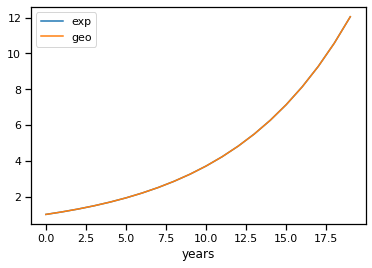

In [49]:
df = pd.DataFrame({
    'years': years,
    'exp': x_exp,
    'geo': x_geo
})

# Check that the total error is small
assert np.sqrt(np.square(df['exp'] - df['geo']).sum()) < 1e-12


df.set_index('years').plot(); # These should be co-incident


Now we should be able to regress on equation(2) to get $\beta = \ln(1+r) $, so $r=e^{\beta}-1$

In [66]:

def exp_line_fit(x,y):
    
    y = np.log(y)
    
    fit = np.polyfit(x,y,1)
    beta, alpha = np.exp(fit)
    
    return beta-1, alpha

r_, b_ = exp_line_fit(df['years'], df['exp'])

# Check that we are close to r
assert round(r_, 6) == r

assert round(b_, 6) == x0
